In [17]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
class cnn_5Layers(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),   # 3*224*224 -> 16*224*224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),   # 16*224*224 -> 16*112*112
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),   # 16*112*112 -> 32*112*112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)  # 32*112*112 -> 32*56*56
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*56*56, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_class)
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [3]:
class cnn_6Layers(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),   # 3*224*224 -> 16*224*224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),   # 16*224*224 -> 16*112*112
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),   # 16*112*112 -> 32*112*112
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),   # 32*112*112 -> 64*112*112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)  # 64*112*112 -> 64*56*56
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*56*56, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_class)
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
test_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
valid_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [6]:
train_dataset = datasets.ImageFolder(root="Recognized/train", transform=train_transformer)
test_dataset = datasets.ImageFolder(root="Recognized/test", transform=test_transformer)
valid_dataset = datasets.ImageFolder(root="Recognized/valid", transform=valid_transformer)

In [7]:
train_loader = DataLoader(dataset=train_dataset, num_workers=0, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, num_workers=0, batch_size=128, shuffle=False)
valid_loader = DataLoader(dataset=valid_dataset, num_workers=0, batch_size=128, shuffle=True)

In [8]:
def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, save_path):
    best_acc = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs,labels in tqdm(train_loader, desc=f"epoch:{epoch+1}/{num_epochs}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"epoch[{epoch+1}/{num_epochs}, Train_loss: {epoch_loss:.4f}]")

        accuracy = evaluate(model, valid_loader, criterion)
        if accuracy > best_acc:
            best_acc = accuracy
            save_model(model, save_path)
            print("Model saved with best accuracy", best_acc)

In [9]:
def evaluate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = valid_loss / len(valid_loader.dataset)
    accuracy = 100.0 * correct / total
    print(f"Valid Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}%")
    return accuracy

In [10]:
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)

In [11]:
num_class = 12
class_names = ["Ants","Bees","Beetles","Caterpillars","Earthworms","Earwigs","Grasshoppers","Moths","Slugs","Snails","Wasps","Weevils"]

In [12]:
model = cnn_5Layers(num_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
# save_path = "model_pth/5-001-256.pth"
save_path = "model_pth/test.pth"

In [12]:
train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, save_path)

epoch:1/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[1/100, Train_loss: 2.2570]
Valid Loss: 2.0579, Accuracy: 30.7233%
Model saved with best accuracy 30.723340790454884


epoch:2/100: 100%|██████████| 60/60 [00:40<00:00,  1.47batch/s]


epoch[2/100, Train_loss: 1.7774]
Valid Loss: 1.8318, Accuracy: 39.5973%
Model saved with best accuracy 39.59731543624161


epoch:3/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[3/100, Train_loss: 1.4256]
Valid Loss: 1.7507, Accuracy: 43.9224%
Model saved with best accuracy 43.92244593586875


epoch:4/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[4/100, Train_loss: 1.1407]
Valid Loss: 1.6886, Accuracy: 43.6242%


epoch:5/100: 100%|██████████| 60/60 [00:40<00:00,  1.48batch/s]


epoch[5/100, Train_loss: 0.8010]
Valid Loss: 1.9112, Accuracy: 44.3699%
Model saved with best accuracy 44.369873228933635


epoch:6/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[6/100, Train_loss: 0.5093]
Valid Loss: 2.3334, Accuracy: 41.4616%


epoch:7/100: 100%|██████████| 60/60 [00:40<00:00,  1.48batch/s]


epoch[7/100, Train_loss: 0.2735]
Valid Loss: 2.5089, Accuracy: 45.9359%
Model saved with best accuracy 45.9358687546607


epoch:8/100: 100%|██████████| 60/60 [00:40<00:00,  1.47batch/s]


epoch[8/100, Train_loss: 0.1285]
Valid Loss: 2.8931, Accuracy: 44.9664%


epoch:9/100: 100%|██████████| 60/60 [00:40<00:00,  1.47batch/s]


epoch[9/100, Train_loss: 0.0533]
Valid Loss: 3.3879, Accuracy: 46.3833%
Model saved with best accuracy 46.38329604772558


epoch:10/100: 100%|██████████| 60/60 [00:40<00:00,  1.48batch/s]


epoch[10/100, Train_loss: 0.0392]
Valid Loss: 3.3905, Accuracy: 46.1596%


epoch:11/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[11/100, Train_loss: 0.0328]
Valid Loss: 3.9125, Accuracy: 44.3699%


epoch:12/100: 100%|██████████| 60/60 [00:40<00:00,  1.46batch/s]


epoch[12/100, Train_loss: 0.0266]
Valid Loss: 4.1143, Accuracy: 43.0276%


epoch:13/100: 100%|██████████| 60/60 [00:40<00:00,  1.47batch/s]


epoch[13/100, Train_loss: 0.0425]
Valid Loss: 4.2094, Accuracy: 43.9224%


epoch:14/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[14/100, Train_loss: 0.0343]
Valid Loss: 4.2407, Accuracy: 43.3259%


epoch:15/100: 100%|██████████| 60/60 [00:41<00:00,  1.43batch/s]


epoch[15/100, Train_loss: 0.0429]
Valid Loss: 3.8726, Accuracy: 45.0410%


epoch:16/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[16/100, Train_loss: 0.0169]
Valid Loss: 4.1604, Accuracy: 43.9970%


epoch:17/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[17/100, Train_loss: 0.0082]
Valid Loss: 4.5714, Accuracy: 43.2513%


epoch:18/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[18/100, Train_loss: 0.0053]
Valid Loss: 4.3744, Accuracy: 46.0850%


epoch:19/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[19/100, Train_loss: 0.0006]
Valid Loss: 4.5366, Accuracy: 46.0850%


epoch:20/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[20/100, Train_loss: 0.0002]
Valid Loss: 4.6421, Accuracy: 46.3087%


epoch:21/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[21/100, Train_loss: 0.0002]
Valid Loss: 4.7289, Accuracy: 46.8307%
Model saved with best accuracy 46.830723340790456


epoch:22/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[22/100, Train_loss: 0.0001]
Valid Loss: 4.8000, Accuracy: 46.8307%


epoch:23/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[23/100, Train_loss: 0.0001]
Valid Loss: 4.8891, Accuracy: 46.7562%


epoch:24/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[24/100, Train_loss: 0.0001]
Valid Loss: 5.0092, Accuracy: 46.6070%


epoch:25/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[25/100, Train_loss: 0.0001]
Valid Loss: 5.1782, Accuracy: 47.1290%
Model saved with best accuracy 47.12900820283371


epoch:26/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[26/100, Train_loss: 0.0001]
Valid Loss: 5.2795, Accuracy: 46.9799%


epoch:27/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[27/100, Train_loss: 0.0001]
Valid Loss: 5.3917, Accuracy: 46.5324%


epoch:28/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[28/100, Train_loss: 0.0001]
Valid Loss: 5.4421, Accuracy: 46.7562%


epoch:29/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[29/100, Train_loss: 0.0000]
Valid Loss: 5.5130, Accuracy: 46.7562%


epoch:30/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[30/100, Train_loss: 0.0000]
Valid Loss: 5.5343, Accuracy: 46.8307%


epoch:31/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[31/100, Train_loss: 0.0000]
Valid Loss: 5.5824, Accuracy: 46.8307%


epoch:32/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[32/100, Train_loss: 0.0000]
Valid Loss: 5.6177, Accuracy: 46.9053%


epoch:33/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[33/100, Train_loss: 0.0000]
Valid Loss: 5.6588, Accuracy: 46.7562%


epoch:34/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[34/100, Train_loss: 0.0000]
Valid Loss: 5.6839, Accuracy: 46.6070%


epoch:35/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[35/100, Train_loss: 0.0000]
Valid Loss: 5.7143, Accuracy: 46.4579%


epoch:36/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[36/100, Train_loss: 0.0000]
Valid Loss: 5.7703, Accuracy: 46.3087%


epoch:37/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[37/100, Train_loss: 0.0000]
Valid Loss: 5.8019, Accuracy: 46.3833%


epoch:38/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[38/100, Train_loss: 0.0000]
Valid Loss: 5.8208, Accuracy: 46.3087%


epoch:39/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[39/100, Train_loss: 0.0000]
Valid Loss: 5.8475, Accuracy: 46.3833%


epoch:40/100: 100%|██████████| 60/60 [00:41<00:00,  1.43batch/s]


epoch[40/100, Train_loss: 0.0000]
Valid Loss: 5.8700, Accuracy: 46.4579%


epoch:41/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[41/100, Train_loss: 0.0000]
Valid Loss: 5.9059, Accuracy: 46.5324%


epoch:42/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[42/100, Train_loss: 0.0000]
Valid Loss: 5.9188, Accuracy: 46.4579%


epoch:43/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[43/100, Train_loss: 0.0000]
Valid Loss: 5.9445, Accuracy: 46.5324%


epoch:44/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[44/100, Train_loss: 0.0000]
Valid Loss: 5.9828, Accuracy: 46.4579%


epoch:45/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[45/100, Train_loss: 0.0000]
Valid Loss: 6.0180, Accuracy: 46.2342%


epoch:46/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[46/100, Train_loss: 0.0000]
Valid Loss: 6.0284, Accuracy: 46.4579%


epoch:47/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[47/100, Train_loss: 0.0000]
Valid Loss: 6.0512, Accuracy: 46.3087%


epoch:48/100: 100%|██████████| 60/60 [00:42<00:00,  1.41batch/s]


epoch[48/100, Train_loss: 0.0000]
Valid Loss: 6.0919, Accuracy: 46.1596%


epoch:49/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[49/100, Train_loss: 0.0000]
Valid Loss: 6.1021, Accuracy: 46.2342%


epoch:50/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[50/100, Train_loss: 0.0000]
Valid Loss: 6.1389, Accuracy: 46.3833%


epoch:51/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[51/100, Train_loss: 0.0000]
Valid Loss: 6.1493, Accuracy: 46.6070%


epoch:52/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[52/100, Train_loss: 0.0000]
Valid Loss: 6.1766, Accuracy: 46.4579%


epoch:53/100: 100%|██████████| 60/60 [00:40<00:00,  1.47batch/s]


epoch[53/100, Train_loss: 0.0000]
Valid Loss: 6.1897, Accuracy: 46.3087%


epoch:54/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[54/100, Train_loss: 0.0000]
Valid Loss: 6.2041, Accuracy: 46.6816%


epoch:55/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[55/100, Train_loss: 0.0000]
Valid Loss: 6.2229, Accuracy: 46.3087%


epoch:56/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[56/100, Train_loss: 0.0000]
Valid Loss: 6.2453, Accuracy: 46.2342%


epoch:57/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[57/100, Train_loss: 0.0000]
Valid Loss: 6.2624, Accuracy: 46.3833%


epoch:58/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[58/100, Train_loss: 0.0000]
Valid Loss: 6.2877, Accuracy: 46.0104%


epoch:59/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[59/100, Train_loss: 0.0000]
Valid Loss: 6.3044, Accuracy: 46.0850%


epoch:60/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[60/100, Train_loss: 0.0000]
Valid Loss: 6.3268, Accuracy: 46.5324%


epoch:61/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[61/100, Train_loss: 0.0000]
Valid Loss: 6.3510, Accuracy: 46.3087%


epoch:62/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[62/100, Train_loss: 0.0000]
Valid Loss: 6.3576, Accuracy: 46.1596%


epoch:63/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[63/100, Train_loss: 0.0000]
Valid Loss: 6.3788, Accuracy: 46.2342%


epoch:64/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[64/100, Train_loss: 0.0000]
Valid Loss: 6.3920, Accuracy: 45.9359%


epoch:65/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[65/100, Train_loss: 0.0000]
Valid Loss: 6.4231, Accuracy: 46.2342%


epoch:66/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[66/100, Train_loss: 0.0000]
Valid Loss: 6.4369, Accuracy: 46.6816%


epoch:67/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[67/100, Train_loss: 0.0000]
Valid Loss: 6.4691, Accuracy: 46.2342%


epoch:68/100: 100%|██████████| 60/60 [00:41<00:00,  1.46batch/s]


epoch[68/100, Train_loss: 0.0000]
Valid Loss: 6.4820, Accuracy: 46.2342%


epoch:69/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[69/100, Train_loss: 0.0000]
Valid Loss: 6.4857, Accuracy: 46.2342%


epoch:70/100: 100%|██████████| 60/60 [00:40<00:00,  1.47batch/s]


epoch[70/100, Train_loss: 0.0000]
Valid Loss: 6.5172, Accuracy: 46.4579%


epoch:71/100: 100%|██████████| 60/60 [00:41<00:00,  1.44batch/s]


epoch[71/100, Train_loss: 0.0000]
Valid Loss: 6.5388, Accuracy: 46.0850%


epoch:72/100: 100%|██████████| 60/60 [00:40<00:00,  1.47batch/s]


epoch[72/100, Train_loss: 0.0000]
Valid Loss: 6.5500, Accuracy: 46.6070%


epoch:73/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[73/100, Train_loss: 0.0000]
Valid Loss: 6.5580, Accuracy: 46.5324%


epoch:74/100: 100%|██████████| 60/60 [00:41<00:00,  1.45batch/s]


epoch[74/100, Train_loss: 0.0000]
Valid Loss: 6.5699, Accuracy: 46.3087%


epoch:75/100:  65%|██████▌   | 39/60 [00:27<00:14,  1.41batch/s]


KeyboardInterrupt: 

In [13]:
def model_evaluation(model, test_loader, device, class_names):
    model.eval()
    all_targets = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Processing batches"):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probabilities = np.array(all_probabilities)

    num_classes = len(class_names)

    # calculate mAP
    y_true_bin = label_binarize(all_targets, classes=range(num_classes))
        
    ap_per_class = []
    for i in range(num_classes):
        ap = average_precision_score(y_true_bin[:, i], all_probabilities[:, i])
        ap_per_class.append(ap)
        
    mean_ap = np.mean(ap_per_class)
        
    print(f"mAP: {mean_ap:.4f}")
    print(f"   Per-class Average Precision:")
    for i, (class_name, ap_val) in enumerate(zip(class_names, ap_per_class)):
        print(f"     {class_name}: {ap_val:.4f}")
    print("\n")
    
    # calculate accuracy, precision, recall, f1
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("\n")
    
    # calculate AUC    
    auc = roc_auc_score(y_true_bin, all_probabilities, average='macro')
    
    print(f"AUC: {auc:.4f}")
        
    auc_per_class = []
    for i in range(num_classes):
        auc_class = roc_auc_score(y_true_bin[:, i], all_probabilities[:, i])
        auc_per_class.append(auc_class)
        
    print(f"   Per-calss AUC:")
    for i, (class_name, auc_val) in enumerate(zip(class_names, auc_per_class)):
        print(f"     {class_name}: {auc_val:.4f}")

    precision_per_class = precision_score(all_targets, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_targets, all_predictions, average=None, zero_division=0)
    f1_per_class = f1_score(all_targets, all_predictions, average=None, zero_division=0)
    
    class_metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-Score': f1_per_class,
        'AP': ap_per_class,
        'AUC': auc_per_class
    })
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'map': mean_ap,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities,
        'class_metrics': class_metrics_df
    }
    
    return results

In [30]:
def plot_comprehensive_results(results, class_names):
    
    num_classes = len(class_names)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Visualization of comprehensive model evaluation results', fontsize=16, fontweight='bold')
    
    # Confusion matrix
    cm = confusion_matrix(results['targets'], results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
    axes[0, 0].set_title('Confusion matrix')
    axes[0, 0].set_xlabel('Predicted label')
    axes[0, 0].set_ylabel('True label')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].tick_params(axis='y', rotation=0)
    
    # Precision, Recall, F1
    metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
    x_pos = np.arange(len(class_names))
    width = 0.25
    
    for i, metric in enumerate(metrics_to_plot):
        axes[0, 1].bar(x_pos + i*width, results['class_metrics'][metric], 
                      width, label=metric, alpha=0.8)
    
    axes[0, 1].set_title('Performance indicators of various categories')
    axes[0, 1].set_xlabel('Category')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_xticks(x_pos + width)
    axes[0, 1].set_xticklabels(class_names, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # ROC(multi-class)
    y_true_bin = label_binarize(results['targets'], classes=range(num_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], results['probabilities'][:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], results['probabilities'][:, i])
    
    colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))
    for i, color in zip(range(num_classes), colors):
        axes[0, 2].plot(fpr[i], tpr[i], color=color, lw=2,
                      label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    axes[0, 2].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0, 2].set_xlim([0.0, 1.0])
    axes[0, 2].set_ylim([0.0, 1.05])
    axes[0, 2].set_xlabel('FP rate')
    axes[0, 2].set_ylabel('TP rate')
    axes[0, 2].set_title('Multi-class ROC curve')
    axes[0, 2].legend(loc="lower right", fontsize=8)
    axes[0, 2].grid(True, alpha=0.3)
    
    # PR Curve (Multi-class)
    precision_dict = dict()
    recall_dict = dict()
    average_precision = dict()
    
    for i in range(num_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(
            y_true_bin[:, i], results['probabilities'][:, i])
        average_precision[i] = average_precision_score(
            y_true_bin[:, i], results['probabilities'][:, i])
    
    colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))
    for i, color in zip(range(num_classes), colors):
        axes[1, 0].plot(recall_dict[i], precision_dict[i], color=color, lw=2,
                      label=f'{class_names[i]} (AP = {average_precision[i]:.2f})')
    
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision ')
    axes[1, 0].set_title('Multi-class PR curve')
    axes[1, 0].legend(loc="lower left", fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)

    
    metrics_radar = ['Precision', 'Recall', 'F1-Score', 'AP', 'AUC']
    radar_data = results['class_metrics'][metrics_radar].values.T
    
    angles = np.linspace(0, 2*np.pi, len(metrics_radar), endpoint=False).tolist()
    angles += angles[:1]
    

    for i in range(min(num_classes, 6)):
        values = radar_data[:, i].tolist()
        values += values[:1]
        axes[1, 1].plot(angles, values, 'o-', linewidth=2, label=class_names[i])
        axes[1, 1].fill(angles, values, alpha=0.1)

    
    axes[1, 1].set_xticks(angles[:-1])
    axes[1, 1].set_xticklabels(metrics_radar)
    axes[1, 1].set_title('Performance indicator radar chart')
    axes[1, 1].legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    axes[1, 1].grid(True, alpha=0.3)
    
    # Summary of Overall Indicators
    summary_metrics = {
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score'],
        'AUC (Macro)': results['auc'],
        'mAP': results['map']
    }
    
    axes[1, 2].axis('off')
    summary_text = "Summary of Overall Indicators:\n\n"
    for metric, value in summary_metrics.items():
        summary_text += f"{metric}: {value:.4f}\n"
    
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes, 
                   fontsize=12, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()


In [28]:
save_path = "model_pth/6-001-128.pth"
model_best = cnn_6Layers(num_class)
state_dict = torch.load(save_path)
model_best.load_state_dict(state_dict)
model_best.to(device)

cnn_6Layers(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=200704, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=12, bias=True)
  )
)

Processing batches: 100%|██████████| 11/11 [00:02<00:00,  5.09it/s]


mAP: 0.5447
   Per-class Average Precision:
     Ants: 0.4847
     Bees: 0.6995
     Beetles: 0.2032
     Caterpillars: 0.5249
     Earthworms: 0.6930
     Earwigs: 0.2528
     Grasshoppers: 0.3826
     Moths: 0.7190
     Slugs: 0.2993
     Snails: 0.6687
     Wasps: 0.7957
     Weevils: 0.8124


Accuracy:  0.5094
Precision: 0.4933
Recall:    0.5094
F1-Score:  0.4847


AUC: 0.8770
   Per-calss AUC:
     Ants: 0.8751
     Bees: 0.9617
     Beetles: 0.7718
     Caterpillars: 0.8420
     Earthworms: 0.9363
     Earwigs: 0.7116
     Grasshoppers: 0.8404
     Moths: 0.9396
     Slugs: 0.7993
     Snails: 0.9161
     Wasps: 0.9739
     Weevils: 0.9559


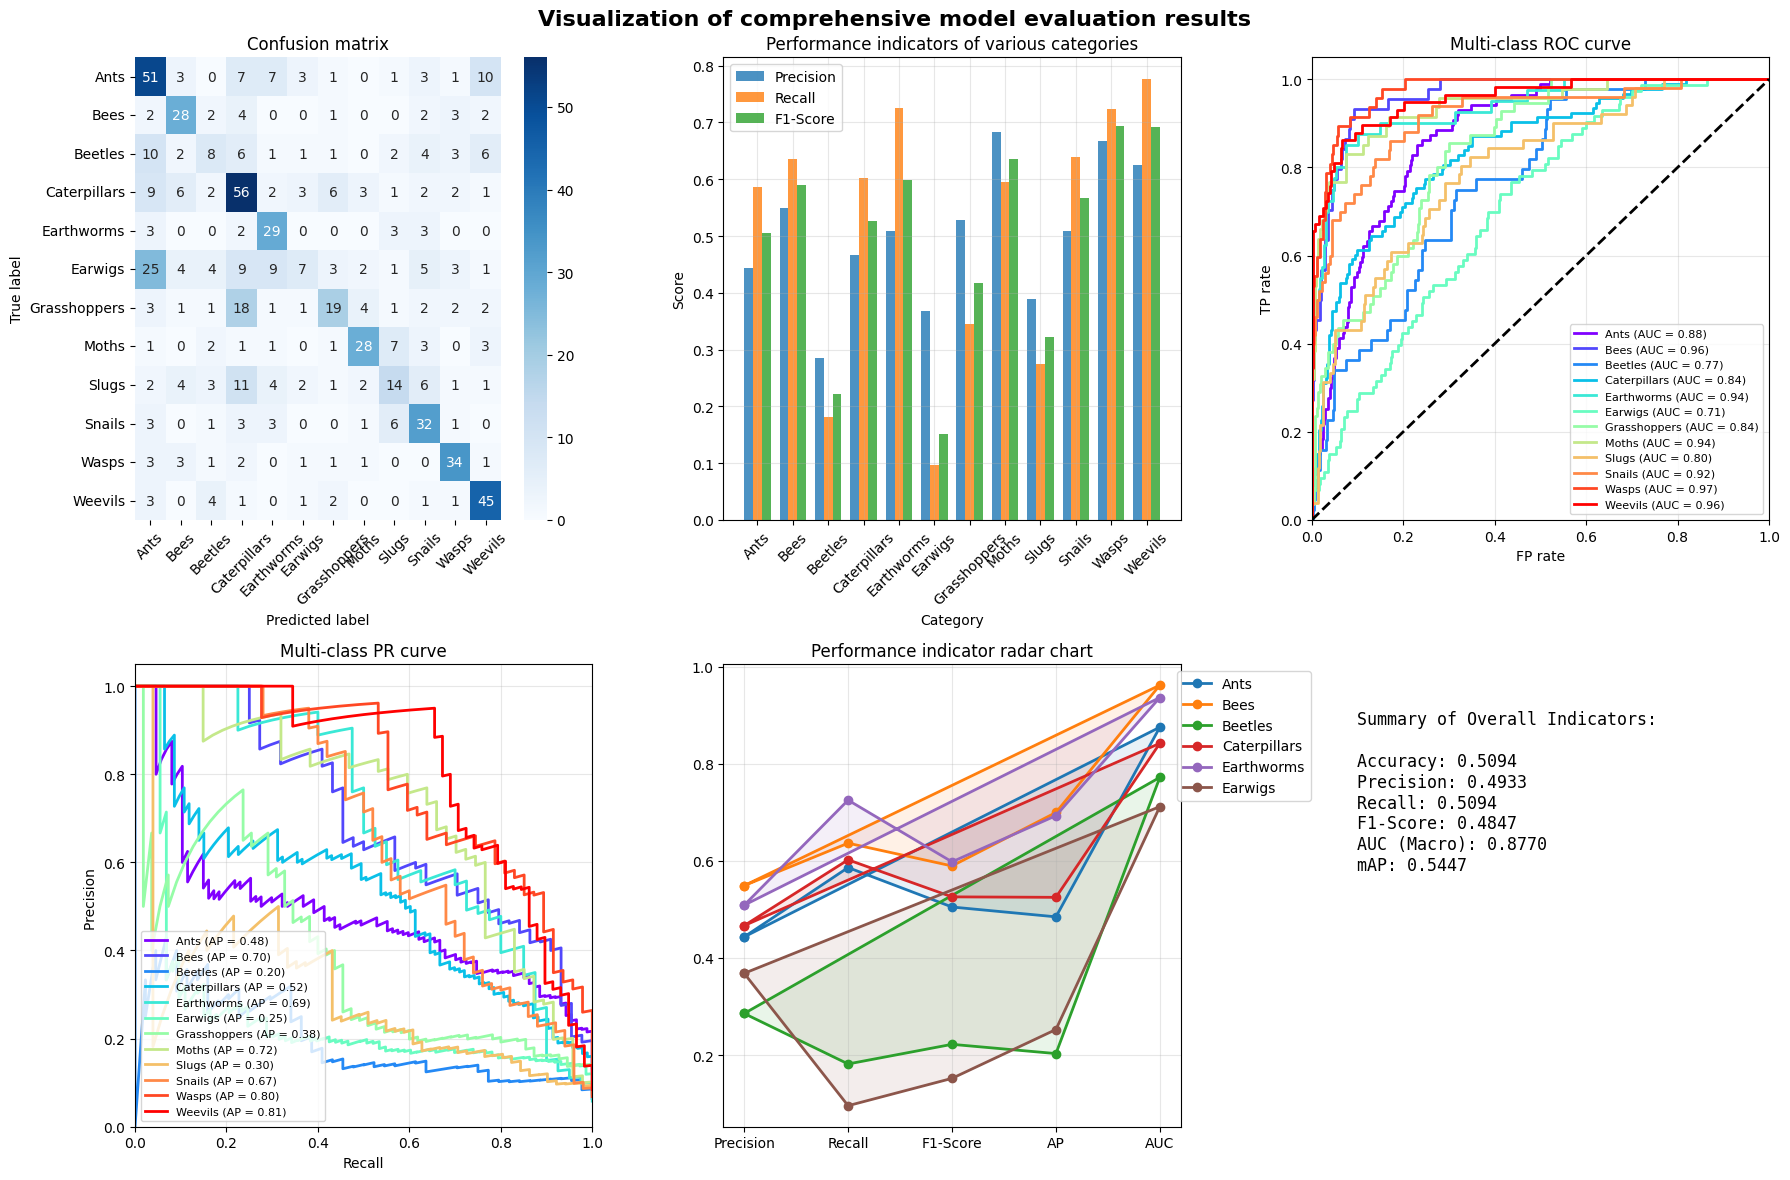

In [31]:
class_names = ["Ants","Bees","Beetles","Caterpillars","Earthworms","Earwigs","Grasshoppers","Moths","Slugs","Snails","Wasps","Weevils"]
results = model_evaluation(model_best, test_loader, device, class_names)
plot_comprehensive_results(results, class_names)

###### 